In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
from scipy import optimize as opt
import matplotlib.pyplot as plt

We take two multivariate random normal processes as return processes and we then consider which portfolio allocation is optimal in a buy and hold setting. We immediately compute mean returns and the return covariance matrix.

In [185]:
mu = np.array([0.1,0.2])
cov = np.array([
    [1.2,  0.7],
    [0.7,  1.9]
])

np.array([
    
])

np.random.seed(112)
returns = np.random.multivariate_normal(mu,cov,size=12)

r1, r2 = returns.T

means = pd.DataFrame((r1.mean(),r2.mean()), index=('r1','r2'),columns=['mean'])
covariances = pd.DataFrame(np.cov((r1,r2)),index=('r1','r2'),columns=('r1','r2'))

display(means)
display(covariances)

,mean
r1,0.032608
r2,-0.018590


,r1,r2
r1,0.428495,0.299774
r2,0.299774,1.323099


Next, we plot the time series return process and squared return process.

<IPython.core.display.Javascript object>


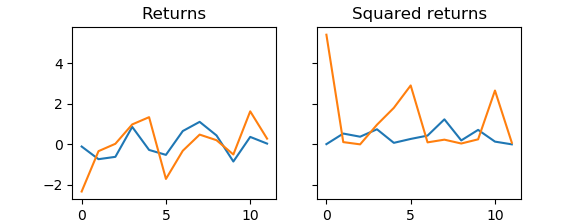

In [186]:
ret_pairs = ((r1, r2),(r1**2,r2**2))
labels = ['Returns','Squared returns']

fig, axes = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,6))
for ax, (r_1,r_2), l in zip(axes.flat, ret_pairs, labels):
    ax.set_title(l)
    ax.plot(r_1)
    ax.plot(r_2)
plt.show()

Now, we need to consider how final wealth and utility is defined. We define final wealth by:

$$  W_T = W_0 \left(   \omega \exp\left\{\sum_{t=1}^T r_t^{(1)}\right\} + (1-\omega) \exp\left\{\sum_{t=1}^T r_t^{(2)}\right\}\right)$$,

where $\omega$ is the weight allocated to asset 1, the remaining being placed in asset 2.

It is natural to have shorting restriction on the weights, such that the following constraints are imposed:

$$ \forall i: \omega_i \in [0,1], \quad \sum_{i} \omega_i = 1$$.

That is, we invest $W_0$ into two assets which have return processes $\{r_t^{(1)}\}_{t\geq 0}$ and $\{r_t^{(2)}\}_{t\geq 0}$.

If we invest DKK 1,000 in asset 1, after 12 months we will have:

In [187]:
om1 = 0.6
w0  = 1000

wT = w0 * (om1 * np.exp(np.sum(r1)/100) + (1 - om1) * np.exp(np.sum(r2)/100))
wT

1001.4610329192175

We see that we have earnt $1,001.46-1,000=207.36$ or approximately 0.1 pct. in one year. This is completely random and can hardly be called an expected return. To have an expected return, we would simulate many paths, perhaps as many as 50,000, and average out the earnings over these simulations.

Let's consider a new process next, numbers taking from an actual estimation. Here we will simulate 50,000 paths.

In [188]:
mu = [0.2543, 0.3492]
cov = [[2.0454, -0.31163],
       [-0.31163, 11.26467]]
months=120
sims = 50000

returns = np.random.multivariate_normal(mu, cov, size = (sims,months))
returns.shape

(50000, 120, 2)

In [189]:
returns = np.transpose(returns, (0,2,1))
returns.shape

(50000, 2, 120)

In [190]:
r1, r2 = returns[:,0,:], returns[:,1,:]
r1.shape

(50000, 120)

In [192]:
avg_process_1 = r1.mean(axis=0)
avg_process_2 = r2.mean(axis=0)

means = pd.DataFrame((avg_process_1.mean(), avg_process_2.mean()),
                     index=['r1','r2'],
                     columns=['mean'])
covariances = pd.DataFrame(np.cov((avg_process_1,avg_process_2)),
                           index=('r1','r2'),
                           columns=('r1','r2'))

display(means)
display(covariances)

plt.plot(avg_process_1)
plt.plot(avg_process_2)
plt.show()

,mean
r1,0.253813
r2,0.349303


,r1,r2
r1,0.000034,-0.000009
r2,-0.000009,0.000242


From the results above, we see that we now have mean returns which match the moments we set up. The variation has been significantly reduced, as variations from each time series manage to an extent to undo variation from other time series.

We can plot the time series to get an idea of how they look.

<IPython.core.display.Javascript object>


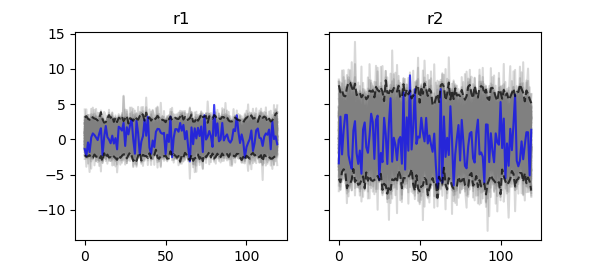

In [193]:
r1_df = pd.DataFrame(r1[:100,:])
r2_df = pd.DataFrame(r2[:100,:])

fig, axes = plt.subplots(nrows=1,ncols=2,sharey=True,figsize=(15,6))
for ax, df, title in zip(axes.flat, (r1_df, r2_df), ['r1','r2']):
    ax.set_title(title)
    ax.plot(df.T, color='grey',alpha=0.3)
    ax.plot(df.iloc[50,:],color='blue',alpha=.7)
    ax.plot(df.quantile(.025),color='black',linestyle='dashed',alpha=.7)
    ax.plot(df.quantile(.975),color='black',linestyle='dashed',alpha=.7)
plt.show()

The above plots show us that there is still considerable variation within the time series, even if the variation of the average time series has been reduced.

Again, we will consider the returns on an investment with $\omega_0$ in asset 1 and the remaining in asset 2.

To do this in python, we first note the dimensions of the return series. Here, r1 is an (sims,periods)-matrix, i.e. of dimension (50,000; 120). In Python, these dimensions are (axis=0, axis=1). What we want to do, is to find the sum over all periods for each simulation, which in Python is done by `np.sum(x, axis=1)`.

This is done below.

<IPython.core.display.Javascript object>


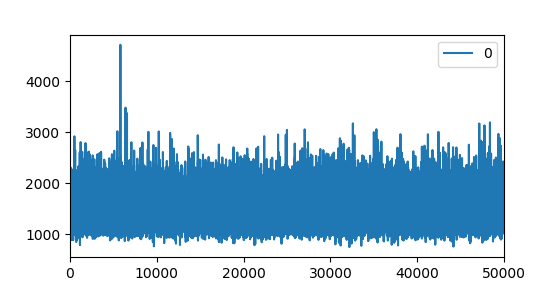

,max,mean,min,q: 2.5,q: 97.5
Portfolio value,[4721.23],[1474.72],[743.8],[1039.94],[2110.65]
Portfolio return,[372.12],[47.47],[-25.62],[3.99],[111.07]


In [194]:
om1 = 0.6
w0  = 1000

cum_ret_1 = np.exp(np.sum(r1, axis = 1)/100)
cum_ret_2 = np.exp(np.sum(r2, axis = 1)/100)

wT = w0 * (om1 * cum_ret_1 + (1 - om1) * cum_ret_2)

wT = pd.DataFrame(wT)

wT.plot()
plt.show()

data = {'mean': np.array(np.round(wT.mean(),2)),
        'min': np.array(np.round(wT.min(),2)),
        'max': np.array(np.round(wT.max(),2)),
        'q: 2.5': np.array(np.round(wT.quantile(.025),2)),
        'q: 97.5': np.array(np.round(wT.quantile(0.975),2))}

dict_variable = {key:np.round((value-w0)/10,2) for key,value in data.items()}

pd.DataFrame((data,dict_variable),
             index=['Portfolio value','Portfolio return'])

We find the expected return to be at approximately $47.5$ pct. which is formidable. Worst case scenario we lose $25.6$ pct., and get a return of $372.1$ pct. in the best case.

In addition, with 95 pct. confidence we will find a return between $4.0$ pct. and $211.1$ pct.

Is this a bet we would like to take? That depends on our utility and the concept of risk aversion.

We will return to this later. First, we want to find the optimal allocation between the two assets.

To do this, we use the scipy.optimize.minimize algorithm:

`opt.minimize(f, parameter, arguments, bounds, constraints, method)`

`f` is the function we want to optimize, `parameter` are the parameters we manipulate until a solution is found, `arguments` are any arguments we need to pass to the function `f`, but which we do not optimise over, `bounds` are the boundaries on our parameters (weights in [0,1]), `constraints` are the set of limitations we impose on the solver (must sum to 1), and `method` is the optimisation approach we take.

First we define the function to be the final wealth, which we negate, as the maximum to the positive is the minimum to the negative, and we are trying to find a minimum.

Before defining the function, we need to see the dimensions of our return processes.

In [195]:
print(r1.shape)
print(r2.shape)
print(r1.sum(axis=1).shape)
print(r2.sum(axis=1).shape)

(50000, 120)
(50000, 120)
(50000,)
(50000,)


From the above, we note that to sum over `periods = 120`, we must sum over `axis=1`. If we do not specify axis, we will do a summation of every single element in the return processes, effectively achieving a sum which is `sims = 50,000` times too large.

In [196]:
def f(w,r1,r2, w0):
    cum_ret_1 = np.exp(np.sum(r1, axis = 1)/100)
    cum_ret_2 = np.exp(np.sum(r2, axis = 1)/100)
    wT = w0 * (w[0] * cum_ret_1 + w[1] * cum_ret_2)
    return - np.mean(wT)

Next, we need to have the parameters (weights, normalised to respect our constraints):

In [197]:
w = np.random.random(2)
w /= np.sum(w)
print(w)

[0.59824691 0.40175309]


We then need to apply constraints and bounds. We do not allow for shorting, so first we impose this with bounds:

In [198]:
def check_sum(weights):
    return np.sum(weights)-1

cons=({'type':'eq','fun': check_sum})

The constraint `cons` tells the solver that the parameter constraint is of type "equality", `eq`. In addition, the function which evaluates this is the function (`fun`): `check_sum`. `check_sum` returns `False` if weights do not sum to `1`, implying that the constraint is not satisfies, and consequently tells the solver to keep working.

We then need to set boundary conditions:

In [199]:
weights=len(w)
bnds = tuple(zip(np.zeros(weights),np.ones(weights)))
bnds

((0.0, 1.0), (0.0, 1.0))

The boundaries are saying that each of the weights we are assigning to parameters (one for `r1` and one for `r2`) must have lower bound `0.0` and upper bound `1.0`.

Finally, we need to pass the arguments. These will be our return processes `r1`, `r2`, and initial wealth invested, `w0`, which we take as given. Thus, they are passed as invariable, i.e. the optimiser should not try to find better return processes, say.

In [200]:
args = r1, r2, w0

We are now ready to solve the problem, as all the elements are in place. We are telling the solver to take the return processes as given, and to experiment with the weights until the maximum return is found (the minimum of the negative). The method we will apply is that of `SLSQP` which is "sequential least squares programming", which is default for constrained optimisation problems.

We might like to test our function first. Here we will use the `asterisk`-operator `*` applied as a prefix to arguments passed into a function, which "unpacks" the arguments in that vector. That is:

`f(w, r1, r2, w0) = f(w, *args)`, for `args = r1, r2, w0`.

In [201]:
-f(w, *args)

1475.166371706483

In [202]:
result = opt.minimize(f, w, args=args, bounds=bnds, constraints=cons, method = 'SLSQP')
print(type(result))
print(result)

<class 'scipy.optimize.optimize.OptimizeResult'>
     fun: -1627.8634162311566
     jac: array([-1372.62255859, -1627.86340332])
 message: 'Optimization terminated successfully.'
    nfev: 8
     nit: 3
    njev: 2
  status: 0
 success: True
       x: array([0., 1.])


We have saved the result to a `class` of `type` "scipy.optimize.optimize.OptimizeResult". This means our result has some properties, amoung which are displayed in the print above. If we want to just access one of the elements, we can add the argument after the dot-operator `.`. As an example, the weights that optimize the value of the portfolio, we notice this is saved as `x`, and the minimised negative of the value is given at `fun`:

In [203]:
print(result.x)
print(-result.fun)

[0. 1.]
1627.8634162311566


Since we have only two assets it is fairly easy to check if the suggested solution is correct.

In [213]:
w = np.arange(0.0, 1.01, 0.01)
weights = np.array((w, 1-w))

y = np.array([-f(weights[:,i],*args) for i in range(len(weights[0,:]))])

print(y.max())

plt.plot(weights[0,:], y)
plt.show()

1627.8634162311566


The above plot shows there is a linear relationship between weight attached to asset 1 (or symmetrically 2) and the value of the portfolio. With 0 weight attached to asset 1 the value of the portfolio is maximised at 1,627.86. These are the results returned by the optimiser also.

Next, we want to consider utility.

In the above analysis, we have attached weight to returns, and no punishment for volatility. We now consider the following CRRA utility function:

$$ u(W_T) = \frac{W_T^{1 - \gamma}}{1-\gamma} $$,

where $\gamma$ is the degree of risk-varsion. Large $\gamma$ implies large degree of risk-aversion and likewise.

In [214]:
def u(w, r1, r2, w0, gamma):
    wT = -f(w, r1, r2, w0)
    u = wT ** (1 - gamma) / (1 - gamma)
    return u

u(w, r1, r2, w0, gamma)

-3.5601488481947424e-06

Here we have reused the function that computes the wealth, as nothing is changed here. Then we compute the utility. We can perform the same operation as before, setting a value of `gamma=5` arbitrarily:

In [215]:
gamma=5.0
args=r1,r2,w0,gamma
y = np.array([u(weights[:,i],*args) for i in range(len(weights[0,:]))])

plt.plot(weights[0,:],y)
plt.show()

As we note, the solution in this case becomes the same. We also note that utility now has no interpretation. We cannot say that a utility of -3.5 is much better than -7.0, as this is a result of the function, which we can change by some monotonic transformation such that the difference may be -3.5 to -3.51 but the optimum remaining the same.

We could consider having three assets.

In [216]:
mu = np.array([
    0.4688,
    0.2543,
    0.7502
])
cov = np.array([
    [1.81257, 1.24255, 2.30530],
    [1.24255, 2.04540, 1.29577],
    [2.30530, 1.29577, 9.15257]
])

np.random.seed(112)
returns = np.random.multivariate_normal(mu,cov,size=12)


r1, r2, r3 = returns.T

for r, title in zip((r1,r2,r3),('r1','r2','r3')):
    plt.plot(r, label=title)
plt.legend()
plt.show()

We cannot at this moment use the functions we have defined above, because they are hardcoded to scenarios of choosing between two assets.

First we note that we could have written the wealth function in vector format. Define the following:

$$ w = (w_1, w_2, w_3)', \quad r = (r_1, r_2, r_3)' $$.

Basic vector rules applied, we can multiply the two vectors as follows:

$$ w' r = (w_1, w_2, w_3) (r_1, r_2, r_3)' = w_1 r_1 + w_2 r_2 + w_3 r_3 = \sum_{i=1}^3 w_i r_i $$.

This operation is true for transformations. For convenience, we write:

$$ g(r) = (g(r_1), g(r_2), g(r_3) $$,

such that:

$$ w' g(r) = \sum_{i=1}^3 w_i g(r_i) $$.

To see why this is useful, we now define $g(\cdot)$:

$$ g(x) = \exp \left\{ \sum_{i} x_i\right\} $$,

where:

$$ x = \pmatrix{x_1 \\ x_2 \\ \vdots \\ x_T} $$.

Thus, to elaborate on $r$, we realise it is in fact a matrix of dimension (assets, periods):

$$ R = \pmatrix{r^{(1)} \\ r^{(2)} \\ \vdots \\ r^{(N)})} = \pmatrix{r_1^{(1)} & r_2^{(1)} & \dots & r_T^{(1)} \\ r_1^{(2)} & r_2^{(2)} & \dots & r_T^{(2)} \\ \vdots & \vdots & \ddots & \vdots \\ r_1^{(N)} & r_2^{(N)} & \dots & r_T^{(N)} }$$,

where $N$ is the amount of assets (3 in our case) and $T$ is the amount of periods (120 for us).

As we noted earlier, `np.sum(x, axis = 1)` will sum across rows. Second, we take the exponential `np.exp(np.sum(R, axis = 1))` will result in:

$$ \exp\left\{ \left(\sum r^{(1)}, \sum r^{(2)}, \sum r^{(3)}\right)'\right\} = \left(\exp\left\{\sum r^{(1)}\right\}, \exp\left\{\sum r^{(2)}\right\}, \exp\left\{\sum r^{(3)}\right\}\right)' = g(R)$$.

Finally, recollecting rules for vector algebra, we take:

$$ W_0 w' g(R) = W_0 \left( w_1 \exp\left\{\sum r^{(1)}\right\} + w_2 \exp\left\{\sum r^{(2)}\right\} + w_3 \exp\left\{\sum r^{(3)}\right\} \right)= W_0 \sum_{i} w_i \exp\left\{ \sum r^{(i)}\right\} = W_T$$.

Thus, generalising our previous function for portfolio wealth simplifies to the below code.

In [217]:
def ultimate_wealth(w0, weights, returns):
    returns = returns.T
    wT = w0 * np.sum( weights * np.exp(np.sum(returns/100, axis = 1)) )
    return -wT

# with equal weights
w = np.repeat(1/3, 3)


-ultimate_wealth(w0, w, returns)

972.6157471942382

The function for utility does not need to be altered, as this takes the ultimate_wealth functions and accepts that functions dimensions.

In [218]:
months=120
sims = 50000

np.random.seed(112)
returns = np.random.multivariate_normal(mu, cov, size = (sims,months))
returns = np.transpose(returns, (0,2,1))
print(returns.shape)
print(np.sum(returns/100, axis=1).shape)
print(np.sum(returns/100, axis=2).shape)

(50000, 3, 120)
(50000, 120)
(50000, 3)


We see from above that, to take account of Monte Carlo simulations, we push the index 1 place to index 2, so that we still sum over each period.

In addition, we need to make sure that the $(w_1, w_2, w_3) (g(r1),g(r2),g(r3))'$ computation is correctly specified with respect to dimensions.

In [219]:
w = np.random.random(3)
w /= np.sum(w)

intermediate_calc = w*np.exp(np.sum(returns/100, axis=2))
print(intermediate_calc.shape)

wT = w0*np.sum(intermediate_calc, axis=1)
print(wT.shape)

(50000, 3)
(50000,)


The above shows us that we want to sum periods `axis=2` in the first addition, and weights multiplied by assets `axis=1` in the second addition, so that we have one terminal value `wT` for each of `sims=50,000` simulations.

In [220]:
def ultimate_wealth(weights, returns, w0):
    wT = w0 * np.sum( weights * np.exp(np.sum(returns, axis = 2)/100) , axis = 1)
    return -wT.mean()

# with equal weights
w = np.repeat(1/3, 3)


-ultimate_wealth(w, returns, w0)

1913.918542424893

With three assets it appears we have managed to improve the expected return to $91.4$ pct.

Optimising the portfolio allocations is now done as before, where we have to update the bounds to be attached to three weights. That is, solve:

$$
\max_{\omega} \frac{1}{N}\sum_{n=1}^N \frac{{W_T^N}^{1-\gamma}}{1-\gamma}, \\
st. \quad \sum \omega = 1, \\
\quad \forall i: \omega_i \in [0,1]
$$

The bounds (constraint 2) are updated to extend dynamically below:

In [221]:
def bounds(weights):
    bnds = tuple(zip(np.zeros(len(weights)),np.ones(len(weights))))
    return bnds

bnds = bounds(w)
bnds

((0.0, 1.0), (0.0, 1.0), (0.0, 1.0))

In [222]:
args = returns, w0

result = opt.minimize(ultimate_wealth, w, args=args, bounds = bnds, constraints = cons, method = 'SLSQP')
print('Overall results: ', result)
print('Optimal portfolio value: ', -result.fun)
print('Optimising portfolio weights: ', result.x)

Overall results:       fun: -2592.586097186386
     jac: array([-1774.44387817, -1374.72567749, -2592.58609009])
 message: 'Optimization terminated successfully.'
    nfev: 11
     nit: 3
    njev: 2
  status: 0
 success: True
       x: array([0., 0., 1.])
Optimal portfolio value:  2592.586097186386
Optimising portfolio weights:  [0. 0. 1.]


Again we find a corner solution to provide the best return (full investment into asset 3). To see this graphically, we need a 3d plot, with weights of assets 1 and 2 on the horizontal axes (x and y), and the expected wealth on the vertical axis (z).

<IPython.core.display.Javascript object>


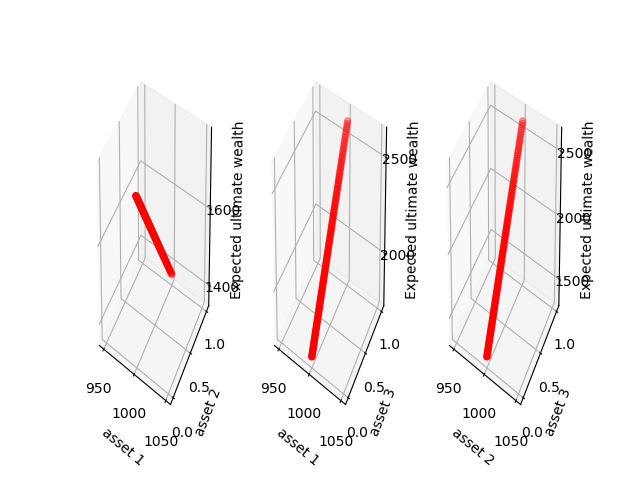

In [223]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

w_0 = np.arange(0,1.01,0.01)
w_1 = 1 - w_0

weights1 = list(zip(w_0, w_1, np.zeros(len(w_0))))
weights2 = list(zip(w_0, np.zeros(len(w_0)), w_1))
weights3 = list(zip(np.zeros(len(w_0)), w_0, w_1))

z1 = np.array([-ultimate_wealth(weights1[i], *args) for i in range(len(w_0))])
z2 = np.array([-ultimate_wealth(weights2[i], *args) for i in range(len(w_0))])
z3 = np.array([-ultimate_wealth(weights3[i], *args) for i in range(len(w_0))])

labels = (('asset 1','asset 2'),('asset 1','asset 3'),('asset 2','asset 3'))
subplots = [1,2,3]
zs = (z1,z2,z3)

fig = plt.figure()
for i, (l1,l2), z in zip(subplots, labels, zs):
    ax = fig.add_subplot(1,3,i, projection='3d')
    ax.scatter(w0,w1,z,c='r',marker='o')
    ax.set_xlabel(l1)
    ax.set_ylabel(l2)
    ax.set_zlabel('Expected ultimate wealth')
plt.show()

The three 3d plots show, that if you must choose between assets 1 and 2, choose 2 with no mixture. If, however, you must choose between assets 1 and 3 or assets 2 and 3, choose asset 3 with no mixture.

We next want to consider maximisation with respect to utility, to see if the results are equally uncompromising.

We first reformulate the wealth function to be positive and not to take the mean. Next, we apply the utility function and instead return the mean of that.

As a final step, we scale the utility by a factor `100,000,000,000,000` to assist the solver, such that improvements are magnified, i.e. easier to notice.

In [224]:
def ultimate_wealth(weights, returns, w0):
    compounded_returns = np.exp(np.sum(returns/100, axis = 2))
    wT = w0*np.sum(weights*compounded_returns, axis = 1)
    return wT

def u(w, returns, w0, gamma):
    wT = ultimate_wealth(w, returns, w0)
    u = wT ** (1 - gamma) / (1 - gamma)
    return -np.mean(u) * 100000000000000

w = np.repeat(1/3,3)
w0 = 1000
gamma = 5.0

args = returns,w0,gamma
u(w,*args)

2.7062543911304076

In [225]:
w = np.random.random(3)
w /= np.sum(w)

gamma=5.0
args=returns,w0,gamma
result = opt.minimize(u, w, args=args, bounds=bnds, constraints=cons, method = 'SLSQP')
result

     fun: 1.6471868333418587
     jac: array([-6.58878243, -5.4157251 , -6.58874415])
 message: 'Optimization terminated successfully.'
    nfev: 25
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.07690239, 0.        , 0.92309761])

In [272]:
print(w)
print(result.x)
print(np.sum(result.x))

[0.66048065 0.13441847 0.20510088]
[0.07690239 0.         0.92309761]
1.0


If the utility is not scaled, it seems the optimiser does nothing to optimise the weights, instead returning the input received as the optimal solution.

With the enormous scaling above, the solver starts looking for a solution, and returns a mix of assets 1 and 2, which we contend with.

It is interesting to see, which asset dominates the portfolio over time, as the returns are compounded. With the given weights above belonging to a buy-and-hold strategy, this is quite simple.

<IPython.core.display.Javascript object>


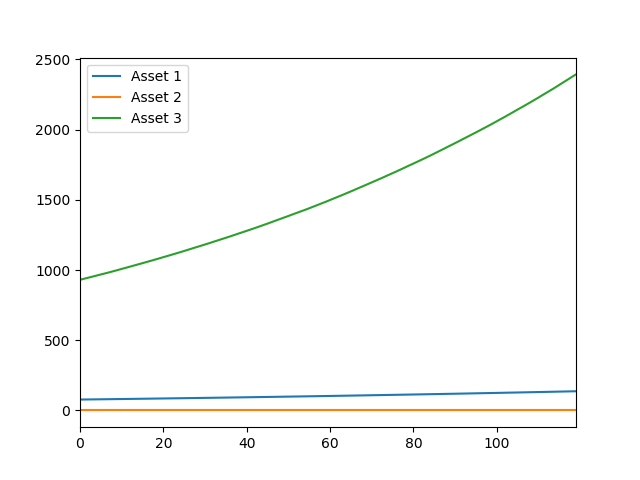

In [268]:
bah_weights=result.x  # (buy and hold)

def weighted_pf(w, returns, w0):
    compounded_returns = np.exp(np.cumsum(returns/100, axis = 2))
    compounded_returns = compounded_returns.mean(axis=0)
    wT = [w0*w*compounded_returns[:,i] for i in range(returns.shape[2])]
    
    columns = ['Asset {}'.format(i + 1) for i in range(returns.shape[1])]
    return pd.DataFrame(wT, columns=columns)

bah_pf_ts = weighted_pf(bah_weights, returns, w0)
bah_pf_ts.plot()

We would likewise be interested in knowing how much each asset constitutes of the portfolio.

     Asset 1  Asset 2  Asset 3
110     0.06     0.00     0.94
111     0.06     0.00     0.94
112     0.06     0.00     0.94
113     0.05     0.00     0.95
114     0.05     0.00     0.95
115     0.05     0.00     0.95
116     0.05     0.00     0.95
117     0.05     0.00     0.95
118     0.05     0.00     0.95
119     0.05     0.00     0.95


<IPython.core.display.Javascript object>


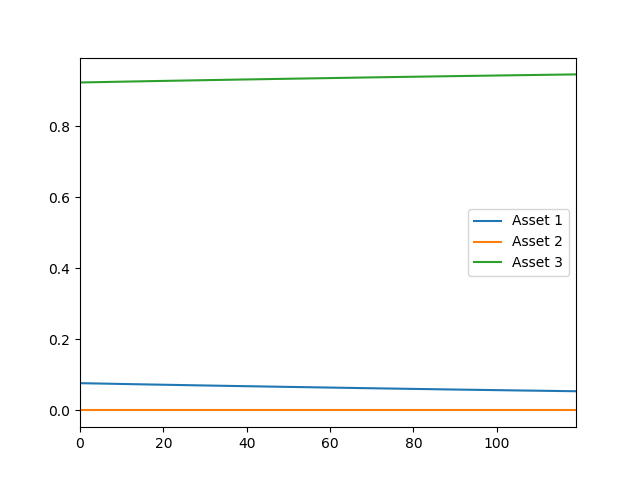

In [360]:
bah_pf_fractions = bah_pf_ts.div(bah_pf_ts.sum(axis=1),axis = 0)
print(bah_pf_fractions.tail(10))
bah_pf_fractions.plot()

We notice that the fraction of the portfolio invested in asset 3 increases systematically. This is due to the higher mean return. If we were able to rebalance, it is possible we may have wanted to distribute the portfolio more evenly across time.

<IPython.core.display.Javascript object>


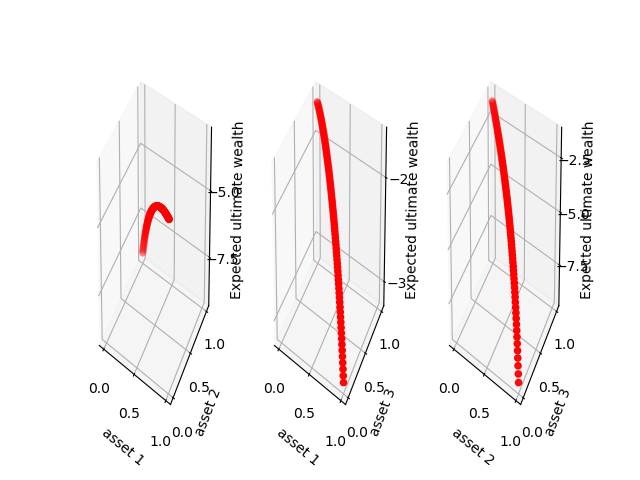

In [329]:
%matplotlib notebook

gamma = 5.0

args = returns, w0, gamma

w_0 = np.arange(0,1.01,0.01)
w_1 = 1 - w_0

weights1 = list(zip(w_0, w_1, np.zeros(len(w_0))))
weights2 = list(zip(w_0, np.zeros(len(w_0)), w_1))
weights3 = list(zip(np.zeros(len(w_0)), w_0, w_1))

z1 = np.array([-u(weights1[i], *args) for i in range(len(w_0))])
z2 = np.array([-u(weights2[i], *args) for i in range(len(w_0))])
z3 = np.array([-u(weights3[i], *args) for i in range(len(w_0))])

subplots = [1,2,3]
labels = (('asset 1','asset 2'),('asset 1','asset 3'),('asset 2','asset 3'))
zs = (z1,z2,z3)

fig = plt.figure()
for i, (l1,l2), z in zip(subplots, labels, zs):
    ax = fig.add_subplot(1,3,i, projection='3d')
    ax.scatter(w_0,w_1,z,c='r',marker='o')
    ax.set_xlabel(l1)
    ax.set_ylabel(l2)
    ax.set_zlabel('Expected ultimate wealth')
plt.show()

#### Here we want utility as high as possible. Between assets 1 and 2 and assets 2 and 3 we have corner solutions, where we want most of asset 1 and asset 3, respectively. That is, we never seem to be interested in asset 2.

Choosing between assets 1 and 3 is fortunately a different story, as we have now found a mixing equilibrium.

At `gamma=5` and an investment horizon of `T=120` months, i.e. 10 years, we find that 7 pct. of the portfolio should be allocated to asset 1, the remaining 93 pct. to asset 3.

## Rebalancing the portfolio

The question is now, if we can rebalance the portfolio, rather than holding it until the end of our investment horizon (maturity), would we find a different allocation?

For this part, we take inspiration from Claus Munk on Dynamic Asset Allocation.

We still have $\omega=(\omega_1, \omega_2, \dots, \omega_N)$, we ignore discounting and consumption. We then want to solve:

$$ J_{t_i} = \max_{(\omega_{t_n})_{n=i}^N} \mathbf{E}_{t_i} [u(W_T)] = \max_{(\omega_{t_i})} \mathbf{E}_{t_i} \left[ \max_{(\omega_{t_i})_{n=i+1}^N}\mathbf{E}_{t_{i+1}} [u(W_T)]\right] = \max_{(\omega_{t_i})} \mathbf{E}_{t_i}\left[ J_{t_{i+1}}\right]. $$

As Claus Munk notes, this procedure lends itself well for a backward iterative solution procedure. We simply start with the last opportunity we have at rebalancing, find the optimum there, and repeat for the penultimate opportunity for rebalancing etc.

Say we rebalance every `t=6` months. For our return sample, that means we have 6 observations left in each return process. We consider now the first return process, recalling that our returns are defined `returns[sims, assets, periods]`.

We first define `r1 = returns[:,0,:]` such that it takes the first asset, but keeps all simulations and all periods.

Next, we pretend that we have already made it to month `120-6=114`, and with the indexing of python, that means we slice `r1` according to `r1_last_rebalance = r1[:,114:]`. We can plot this period:

<IPython.core.display.Javascript object>


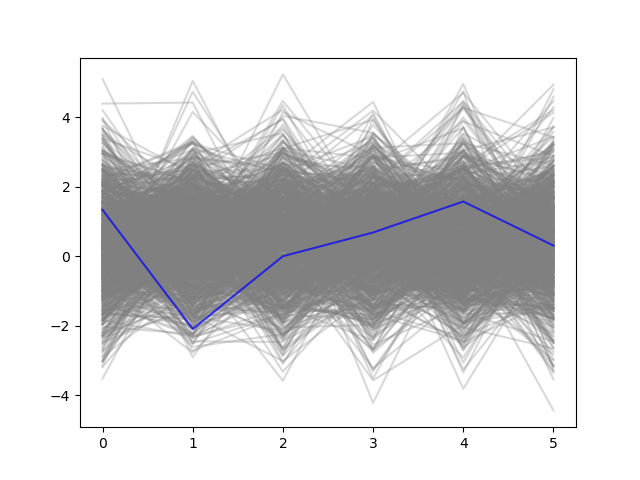

In [330]:
r1 = returns[:,0,114:]

plt.plot(r1[:1000,:].T, color='grey',alpha=0.3)
plt.plot(r1[50,:].T,color='blue',alpha=.7)
plt.show()

We now want to find out what the optimal portfolio allocation would be, if we could rebalance with 6 months left of our investment horizon. The problem to solve is consequently similar to what it has been previously:

In [179]:
returns_reb = returns[:,:,114:]

w = np.random.random(3)
w /= np.sum(w)

w0 = 1000
gamma=5.0

args=returns_reb,w0,gamma
result = opt.minimize(u, w, args=args, bounds=bnds, constraints=cons, method = 'SLSQP')
result

     fun: 21.80252009781627
     jac: array([-87.21010423, -86.3487072 , -87.21007514])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.0718648, 0.       , 0.9281352])

The result is very similar to the previous result. With a process that is normally distributed and 50,000 simulations this could perhaps be expected.

To compare what we had 6 months before the end of the investment horizon, had we let the optimal allocation run, we can recall our portfolio from before.

In [332]:
print(np.round(result.x*100,2))
np.round(bah_pf_fractions.tail(6)*100,2)

[ 7.69  0.   92.31]


,Asset 1,Asset 2,Asset 3
114,5.48,0.0,94.52
115,5.46,0.0,94.54
116,5.44,0.0,94.56
117,5.43,0.0,94.57
118,5.41,0.0,94.59
119,5.39,0.0,94.61


We note a percentage difference of more than two percentage points. We can let the rebalancing run every 6 months.

<IPython.core.display.Javascript object>


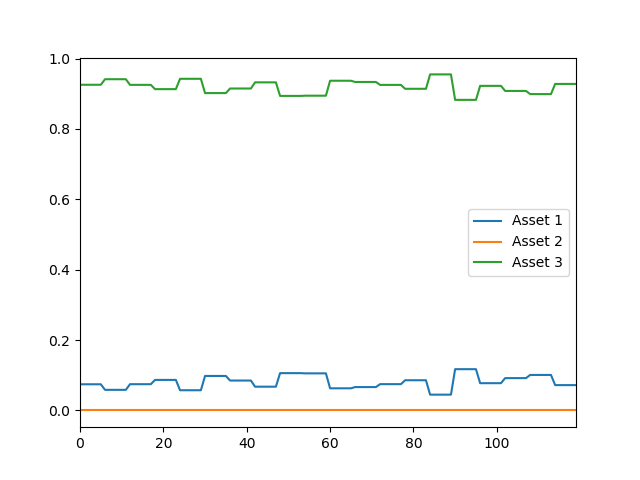

In [339]:
w = np.random.random(3)
w /= np.sum(w)

w0 = 1000
gamma=5.0

weights = np.zeros((120,3))

for i in range(20):
    args = returns[:,:,114-i*6:120-i*6], w0, gamma
    weights[120-6*(i+1):120-6*i,:] = opt.minimize(u,
                                                  w,
                                                  args=args,
                                                  bounds=bnds,
                                                  constraints=cons,
                                                  method='SLSQP').x

columns = ['Asset {}'.format(i+1) for i in range(returns.shape[1])]
reb_weights=pd.DataFrame(weights, columns = columns)
reb_weights.plot()

The above `weights` now contain the rebalanced weights at all points in time.

We note that this is quite different to the portfolio allocation witnessed in the buy-and-hold strategy, where we had a passive increase in weight allocated to asset 3. In fact, if anything, there seems to be an increasing trend in the allocation towards asset 1, when rebalancing is allowed.

<IPython.core.display.Javascript object>


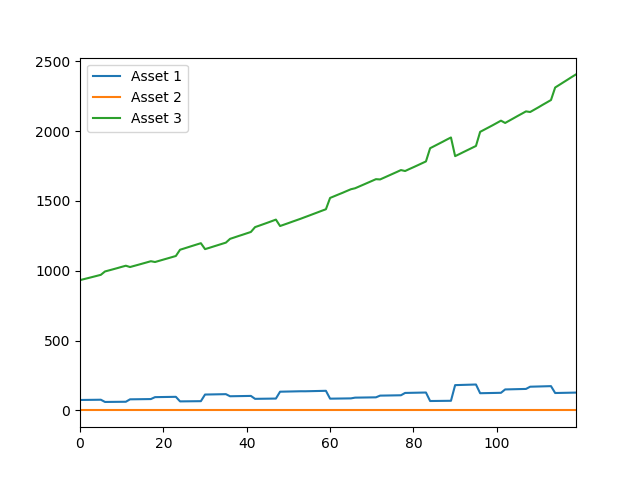

In [348]:
compounded_returns = np.exp(np.cumsum(returns/100, axis = 2))
compounded_returns = compounded_returns.mean(axis=0)
wT = [w0*weights[i,:]*compounded_returns[:,i] for i in range(returns.shape[2])]

columns = ['Asset {}'.format(i + 1) for i in range(returns.shape[1])]

reb_pf_ts = pd.DataFrame(wT, columns=columns)
reb_pf_ts.plot()

Int the above plot we are still seeing an increasing proportion of the portoflio allocated to asset 3.

The proportions can as before be plotted, see below.

      Asset 1       Asset 2   Asset 3
90   0.090426  7.474472e-17  0.909574
91   0.090175  7.437424e-17  0.909825
92   0.089910  7.399736e-17  0.910090
93   0.089664  7.363236e-17  0.910336
94   0.089422  7.327403e-17  0.910578
95   0.089189  7.292943e-17  0.910811
96   0.058098  1.556183e-17  0.941902
97   0.057928  1.548406e-17  0.942072
98   0.057761  1.540704e-17  0.942239
99   0.057595  1.533062e-17  0.942405
100  0.057418  1.525035e-17  0.942582
101  0.057241  1.517006e-17  0.942759
102  0.067974  0.000000e+00  0.932026
103  0.067765  0.000000e+00  0.932235
104  0.067562  0.000000e+00  0.932438
105  0.067363  0.000000e+00  0.932637
106  0.067176  0.000000e+00  0.932824
107  0.066988  0.000000e+00  0.933012
108  0.073551  9.238469e-17  0.926449
109  0.073339  9.191497e-17  0.926661
110  0.073131  9.145424e-17  0.926869
111  0.072908  9.098277e-17  0.927092
112  0.072708  9.054359e-17  0.927292
113  0.072499  9.008994e-17  0.927501
114  0.051098  0.000000e+00  0.948902
115  0.05093

<IPython.core.display.Javascript object>


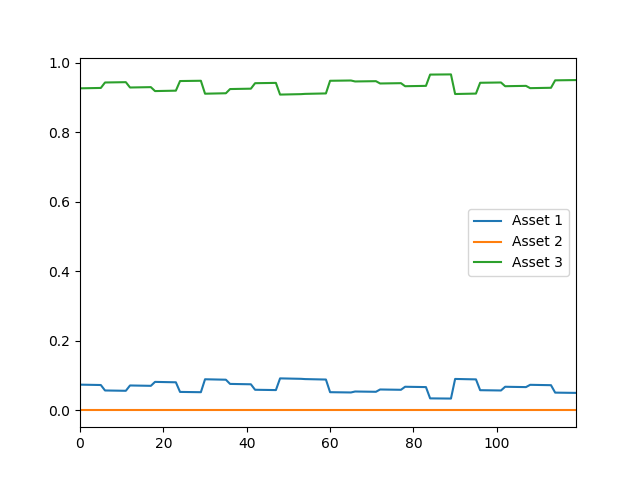

In [351]:
reb_pf_fractions = reb_pf_ts.div(reb_pf_ts.sum(axis=1),axis = 0)
print(reb_pf_fractions.tail(30))
reb_pf_fractions.plot()

It is hard to infer from the above, that anything has changed particularly. We could instead look at the average portfolio allocation, whereas Sharpe ratio is seemingly infeasible as we have time-varying portfolio weights with a constant covariance-matrix.

In [362]:
pd.options.display.float_format = '{:.2f}'.format
print(reb_pf_fractions.mean(axis=0)*100)
print(reb_pf_fractions.min(axis=0)*100)
print(reb_pf_fractions.max(axis=0)*100)

print(bah_pf_fractions.mean(axis=0)*100)
print(bah_pf_fractions.min(axis=0)*100)
print(bah_pf_fractions.max(axis=0)*100)


Asset 1    6.73
Asset 2    0.00
Asset 3   93.27
dtype: float64
Asset 1    3.40
Asset 2    0.00
Asset 3   90.79
dtype: float64
Asset 1    9.21
Asset 2    0.00
Asset 3   96.60
dtype: float64
Asset 1    6.47
Asset 2    0.00
Asset 3   93.53
dtype: float64
Asset 1    5.39
Asset 2    0.00
Asset 3   92.33
dtype: float64
Asset 1    7.67
Asset 2    0.00
Asset 3   94.61
dtype: float64


With respect to averages, we see that the rebalancing portfolio has a slightly smaller proportion of the portfolio allocated to the heavy asset 3, which we believed would be the natural correction.

We also see that the rebalancing opportunity is actually used actively, with great variation in allocations to assets 1 and 3 around their mean, respectively.